# Trafic Signs Recognition

### Check if tensorflow will use GPU

In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Import required packages

In [3]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import backend as K
# K.tensorflow_backend._get_available_gpus()
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

root_dir = 'GTSRB\\Final_Training\\Images\\'

print("finish step 1")

finish step 1


## Get to know dataset

In [14]:
all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
print("Number singns in training set: {}".format(len(all_img_paths)))
number_of_classes = glob.glob(os.path.join(root_dir, '*/00000_00000.ppm'))
print("Number of classes: {}".format(len(number_of_classes)))

Number singns in training set: 39209
Number of classes: 43


Example sign from each class


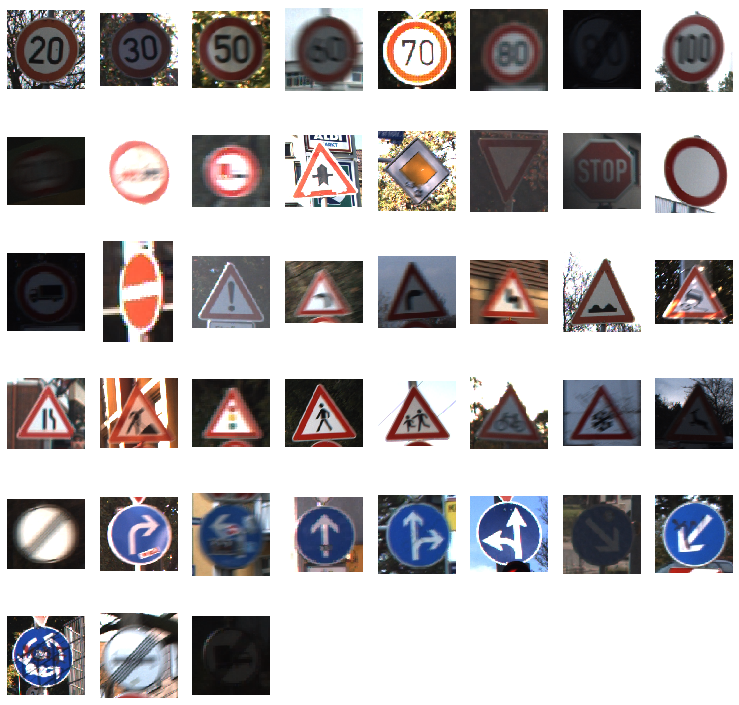

In [104]:
from matplotlib.pyplot import figure, imshow, axis, tight_layout
from matplotlib.image import imread

def showImagesInGrid(list_of_files):
    fig = figure(figsize=(13, 13))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files/7,8,i+1)
        image = imread(list_of_files[i])
        imshow(image)
        axis('off')

print("Example sign from each class")
image_from_each_class_paths = glob.glob(os.path.join(root_dir, '*/00002_00029.ppm'))
showImagesInGrid(image_from_each_class_paths)

Sample class trainig examples

Example signs from one class


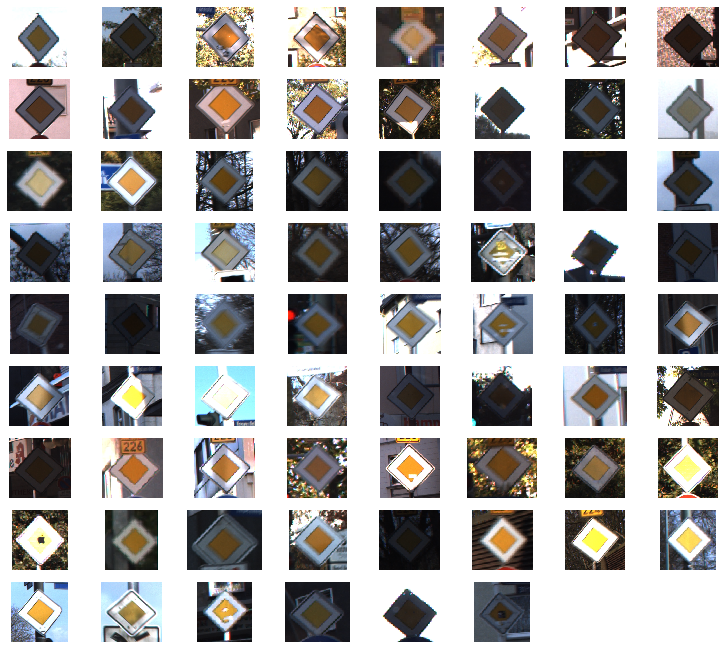

In [105]:
examples_from_class = 12

examples_from_one_class_path = '*0{}/*_00029.ppm'.format(examples_from_class)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

Each sign real life sign in dataset has already generated 30 variation of it 

Example signs from one class


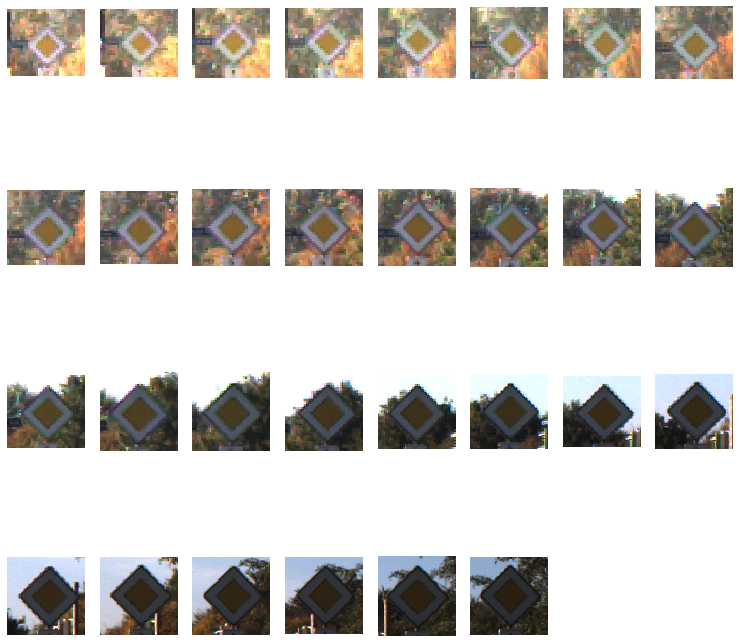

In [110]:
examples_from_class = 12
sign_no_varations = 1

examples_from_one_class_path = '*0{}/*0{}_*.ppm'.format(examples_from_class, sign_no_varations)
print("Example signs from one class")
image_from_one_class_paths = glob.glob(os.path.join(root_dir, examples_from_one_class_path))
showImagesInGrid(image_from_one_class_paths)

## Function to preprocess the image:

In [7]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('\\')[-2])
print("finish step 2")

finish step 2


## Preprocess all training images into a numpy array

In [2]:
try:
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    print(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%100 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

    print("finish step 3")
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")

NameError: name 'glob' is not defined

# Define Keras model

In [16]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

print("finish step 4")

finish step 4


# Start Training

In [ ]:
batch_size = 32
nb_epoch = 30

model.fit(X, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True
          ,callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 15s 469us/sample - loss: 0.1764 - accuracy: 0.9449 - val_loss: 0.0751 - val_accuracy: 0.9782
Epoch 2/30
31367/31367 [==============================] - 14s 452us/sample - loss: 0.1250 - accuracy: 0.9609 - val_loss: 0.0538 - val_accuracy: 0.9838
Epoch 3/30
31367/31367 [==============================] - 15s 465us/sample - loss: 0.0961 - accuracy: 0.9702 - val_loss: 0.0461 - val_accuracy: 0.9869
Epoch 4/30
31367/31367 [==============================] - 14s 459us/sample - loss: 0.0808 - accuracy: 0.9750 - val_loss: 0.0357 - val_accuracy: 0.9908
Epoch 5/30
31367/31367 [==============================] - 15s 466us/sample - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.0317 - val_accuracy: 0.9912
Epoch 6/30
31367/31367 [==============================] - 14s 459us/sample - loss: 0.0653 - accuracy: 0.9794 - val_loss: 0.0377 - val_accuracy: 0.9901
Epoch 7/30
31367/31367 [=====================

# Load Test data

In [37]:
import pandas as pd
test = pd.read_csv('GT-final_test.csv',sep=';')

X_test = []
y_test = []
i = 0
print("list lenght {})".format(len(list(test['Filename']))))
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB\\Final_Test\\Images\\',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    if len(X_test)%10 == 0: print("Processed {}/{}".format(len(X_test), len(y_test)))
    
    
X_test = np.array(X_test)
y_test = np.array(y_test)

list lenght 12630)
Processed 10/10
Processed 20/20
Processed 30/30
Processed 40/40
Processed 50/50
Processed 60/60
Processed 70/70
Processed 80/80
Processed 90/90
Processed 100/100
Processed 110/110
Processed 120/120
Processed 130/130
Processed 140/140
Processed 150/150
Processed 160/160
Processed 170/170
Processed 180/180
Processed 190/190
Processed 200/200
Processed 210/210
Processed 220/220
Processed 230/230
Processed 240/240
Processed 250/250
Processed 260/260
Processed 270/270
Processed 280/280
Processed 290/290
Processed 300/300
Processed 310/310
Processed 320/320
Processed 330/330
Processed 340/340
Processed 350/350
Processed 360/360
Processed 370/370
Processed 380/380
Processed 390/390
Processed 400/400
Processed 410/410
Processed 420/420
Processed 430/430
Processed 440/440
Processed 450/450
Processed 460/460
Processed 470/470
Processed 480/480
Processed 490/490
Processed 500/500
Processed 510/510
Processed 520/520
Processed 530/530
Processed 540/540
Processed 550/550
Processed

Processed 4220/4220
Processed 4230/4230
Processed 4240/4240
Processed 4250/4250
Processed 4260/4260
Processed 4270/4270
Processed 4280/4280
Processed 4290/4290
Processed 4300/4300
Processed 4310/4310
Processed 4320/4320
Processed 4330/4330
Processed 4340/4340
Processed 4350/4350
Processed 4360/4360
Processed 4370/4370
Processed 4380/4380
Processed 4390/4390
Processed 4400/4400
Processed 4410/4410
Processed 4420/4420
Processed 4430/4430
Processed 4440/4440
Processed 4450/4450
Processed 4460/4460
Processed 4470/4470
Processed 4480/4480
Processed 4490/4490
Processed 4500/4500
Processed 4510/4510
Processed 4520/4520
Processed 4530/4530
Processed 4540/4540
Processed 4550/4550
Processed 4560/4560
Processed 4570/4570
Processed 4580/4580
Processed 4590/4590
Processed 4600/4600
Processed 4610/4610
Processed 4620/4620
Processed 4630/4630
Processed 4640/4640
Processed 4650/4650
Processed 4660/4660
Processed 4670/4670
Processed 4680/4680
Processed 4690/4690
Processed 4700/4700
Processed 4710/4710


Processed 8320/8320
Processed 8330/8330
Processed 8340/8340
Processed 8350/8350
Processed 8360/8360
Processed 8370/8370
Processed 8380/8380
Processed 8390/8390
Processed 8400/8400
Processed 8410/8410
Processed 8420/8420
Processed 8430/8430
Processed 8440/8440
Processed 8450/8450
Processed 8460/8460
Processed 8470/8470
Processed 8480/8480
Processed 8490/8490
Processed 8500/8500
Processed 8510/8510
Processed 8520/8520
Processed 8530/8530
Processed 8540/8540
Processed 8550/8550
Processed 8560/8560
Processed 8570/8570
Processed 8580/8580
Processed 8590/8590
Processed 8600/8600
Processed 8610/8610
Processed 8620/8620
Processed 8630/8630
Processed 8640/8640
Processed 8650/8650
Processed 8660/8660
Processed 8670/8670
Processed 8680/8680
Processed 8690/8690
Processed 8700/8700
Processed 8710/8710
Processed 8720/8720
Processed 8730/8730
Processed 8740/8740
Processed 8750/8750
Processed 8760/8760
Processed 8770/8770
Processed 8780/8780
Processed 8790/8790
Processed 8800/8800
Processed 8810/8810


Processed 12200/12200
Processed 12210/12210
Processed 12220/12220
Processed 12230/12230
Processed 12240/12240
Processed 12250/12250
Processed 12260/12260
Processed 12270/12270
Processed 12280/12280
Processed 12290/12290
Processed 12300/12300
Processed 12310/12310
Processed 12320/12320
Processed 12330/12330
Processed 12340/12340
Processed 12350/12350
Processed 12360/12360
Processed 12370/12370
Processed 12380/12380
Processed 12390/12390
Processed 12400/12400
Processed 12410/12410
Processed 12420/12420
Processed 12430/12430
Processed 12440/12440
Processed 12450/12450
Processed 12460/12460
Processed 12470/12470
Processed 12480/12480
Processed 12490/12490
Processed 12500/12500
Processed 12510/12510
Processed 12520/12520
Processed 12530/12530
Processed 12540/12540
Processed 12550/12550
Processed 12560/12560
Processed 12570/12570
Processed 12580/12580
Processed 12590/12590
Processed 12600/12600
Processed 12610/12610
Processed 12620/12620
Processed 12630/12630


In [38]:
y_pred = model.predict_classes(X_test)
print(y_pred)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

[16  1 38 ... 15  7 10]
Test accuracy = 0.9725257323832146


# With Data augmentation

In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train)

In [10]:
# Reinstallise models 

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [11]:
nb_epoch = 30
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

Epoch 1/30
31367/31367 [==============================] - 27s - loss: 2.0311 - acc: 0.4023 - val_loss: 0.4975 - val_acc: 0.8258
Epoch 2/30
31367/31367 [==============================] - 31s - loss: 0.7059 - acc: 0.7762 - val_loss: 0.2078 - val_acc: 0.9341
Epoch 3/30
31367/31367 [==============================] - 31s - loss: 0.4047 - acc: 0.8763 - val_loss: 0.1255 - val_acc: 0.9621
Epoch 4/30
31367/31367 [==============================] - 31s - loss: 0.2769 - acc: 0.9125 - val_loss: 0.0875 - val_acc: 0.9717
Epoch 5/30
31367/31367 [==============================] - 31s - loss: 0.2266 - acc: 0.9308 - val_loss: 0.0459 - val_acc: 0.9865
Epoch 6/30
31367/31367 [==============================] - 30s - loss: 0.1931 - acc: 0.9416 - val_loss: 0.0488 - val_acc: 0.9850
Epoch 7/30
31367/31367 [==============================] - 31s - loss: 0.1737 - acc: 0.9477 - val_loss: 0.0383 - val_acc: 0.9881
Epoch 8/30
31367/31367 [==============================] - 31s - loss: 0.1461 - acc: 0.9563 - val_loss: 0

In [12]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

12630/12630 [==============================] - 3s     
Test accuracy = 0.9828978622327791


In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_7 (Convolution2D)    (None, 32, 48, 48)  896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)    (None, 32, 46, 46)  9248        convolution2d_7[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)      (None, 32, 23, 23)  0           convolution2d_8[0][0]            
____________________________________________________________________________________________________
dropout_5 (Dropout)                (None, 32, 23, 23)  0           maxpooling2d_4[0][0]             
___________________________________________________________________________________________

In [14]:
model.count_params()

1358155